# ENTREGA MODELO SENCILLO
#### Sara Blanco López
#### Josep Peiró Ramos

In [186]:
import os
from preprocessing import Preprocessing, SplitAudio, Reconstruction
import torchaudio

import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

from torch import nn
import torch.optim as optim

from torchinfo import summary

import matplotlib.pyplot as plt

from IPython.display import Audio

import requests
import io

Para este trabajo vamos a mostrar el archivo ejecutado. 

Hemos creado un autoencoder todo lo simple posible, y lo hemos entrenado con un conjunto relativamente pequeño de datos a modo de ejemplo. Estamos trabajando con datos de datos de audio, pero de los cuales extraemos el espectograma de mel, y con la descomposición obtenemos un conjunto de 256 x 256 atributos, en 1 solo canal. Así podemos utilizar capas convolucionales para extraer características de frecuancia y temporales de los datos para el autoencoder.

Hemos utilizado pytorch para programar el autoencoder.

Se debe tener en cuenta que son necesarias tener todos los archivos que estamos subiendo en la tarea en una misma carpeta para que esto pueda ejecutarse correctamente.

Lo primero que hacemos es cargar y preprocesar los datos. Una explicación más detallada de este proceso puede ser encontrada en la tarea previa de entrega de conjunto de datos.

Para entrenar el autoencoder utilizamos 100 audios que se convertirán en 200 muestras.

In [187]:
usuario = "JosepPeiro"
repositorio = "Perceptual-Metrics-VAE"
directorio = "MICROMUESTRA%20DATOS"
branch = "main"

url = f"https://api.github.com/repos/{usuario}/{repositorio}/contents/{directorio}?ref={branch}"

response = requests.get(url)
content = response.json()
archivos = [archivo["name"] for archivo in content]

In [188]:
ruta_carpeta = "./MusicCaps"  # Ruta a los datos

# archivos = os.listdir(ruta_carpeta)

X = []
metadata = []
sample_rate_red = 16000
for archivo in archivos[:100]:
    url_arch = f"https://raw.githubusercontent.com/{usuario}/{repositorio}/{branch}/{directorio}/" + archivo
    respuesta = requests.get(url_arch)
    waveform, samp_rt = torchaudio.load(io.BytesIO(respuesta.content))

    # waveform, samp_rt = torchaudio.load(ruta_carpeta + "/" + archivo)
    f, s = SplitAudio(waveform, sample_rate = samp_rt, new_sample_rate = sample_rate_red)

    f_spec, f_maxi, f_mini = Preprocessing(f, 16000, resampler_f = False)
    s_spec, s_maxi, s_mini = Preprocessing(s, 16000, resampler_f = False)

    if not torch.isnan(f_spec).any():
        X += [f_spec]
        metadata += [{"nombre":archivo, "parte":"first", "minimum":f_mini, "maximum":f_maxi}]
    if not torch.isnan(s_spec).any():
        X += [s_spec]
        metadata += [{"nombre":archivo, "parte":"second", "minimum":f_mini, "maximum":f_maxi}]

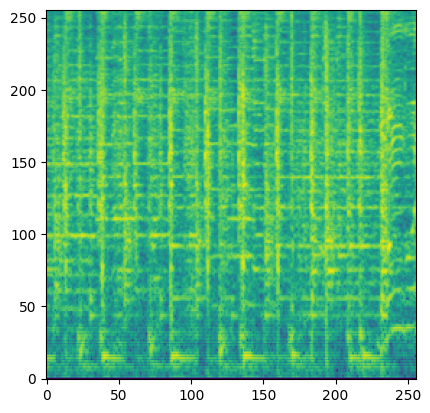

In [189]:
plt.imshow(s_spec,origin='lower') # Mostramos ese espectograma
plt.show()

Una vez con una lista de datos, debemos añadir el canal y crear batches.

Vamos a dividir conjunto de train y validación. Dejaremos el 80% de datos de entrenamiento y el 20% restante para validación, de esta manera, como teníamos 200 muestras, 160 pasarán a train y 40 a validarse.

Como este ejercicio intenta ser simple los batches serán de 8 datos, y como tenemos un total de 200 datos, se crean 25 batches, 20 de entrenamiento y 5 de validacion.

In [190]:
X_tensor = torch.stack(X)  # (N, 256, 256)
X_tensor = X_tensor.unsqueeze(1)  # (N, 1, 256, 256)
print(X_tensor.shape)

train_size = int(0.8 * len(X_tensor))
val_size = len(X_tensor) - train_size
train_dataset, val_dataset = random_split(TensorDataset(X_tensor), [train_size, val_size])

batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print(len(train_dataloader))
print(len(valid_dataloader))

torch.Size([199, 1, 256, 256])
20
5


# MODELO PARA LA ENTREGA

## Creación del modelo

Para este primer modelo, al ser un autoencoder por supuesto se compone de la parte del encoder y del decoder.

Para simplificarlo todo lo posible el encoder va a tener únicamente una capa convolucional en 2 dimensiones y una tangente hiperbólica para que las variables latentes estén entre -1 y 1. Para garantizar el correcto funcionamiento y utilidad del autoencoder vamos a reducir el número de dimensiones del espacio latente respecto de los datos de entrada a la mitad. Así los datos tienen dimensión 1 x 256 x 256, y las variables latentes tendrán 2 x 128 x 128, la mitad de atributos.

Por otra parte, para el decoder vamos a utilizar una capa convolucional transpuesta en 2 diemnsiones, a la que aplicaremos 4 filtros, así se volverá a generar el tamaño de 256 x 256. Además añadiremos una última capa convolucional para que la contidad de filtros pase a ser 1 de nuevo, y de esta manera recuperamos el tamaño original 1 x 256 x 256. Finalmente añadimos una función de activación de sigmoide necesario porque nuestros datos están entre 0 y 1.

In [191]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=2, padding=1),  # Reduce tamaño a 128x128
            nn.Tanh()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=2, out_channels=4, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Conv2d(in_channels=4, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.SGD(autoencoder.parameters(), lr=0.01, momentum=0.9)


Vemos un resumen del modelo generado.

In [192]:
summary(autoencoder, input_size=(64, 1, 256, 256))  # (batch_size, channels, height, width)

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [64, 1, 256, 256]         --
├─Sequential: 1-1                        [64, 2, 128, 128]         --
│    └─Conv2d: 2-1                       [64, 2, 128, 128]         20
│    └─Tanh: 2-2                         [64, 2, 128, 128]         --
├─Sequential: 1-2                        [64, 1, 256, 256]         --
│    └─ConvTranspose2d: 2-3              [64, 4, 256, 256]         76
│    └─Conv2d: 2-4                       [64, 1, 256, 256]         37
│    └─Sigmoid: 2-5                      [64, 1, 256, 256]         --
Total params: 133
Trainable params: 133
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 494.93
Input size (MB): 16.78
Forward/backward pass size (MB): 184.55
Params size (MB): 0.00
Estimated Total Size (MB): 201.33

## Entrenar el modelo

Vamos finalmente a entrenar el modelo definido previamente con los datos como hemos especificado al principio.

Como la cantidad de datos es reducida y el modelo es muy simple, el proceso de entrenamiento es rápido, vamos a entrenar 10 épocas para ver cómo evolucionan los resultados de train y validación. Al final de cada época comprobamos cómo reconstruye los datos almacenados de validación.

In [193]:
num_epochs = 30

perdida_train = []
perdida_epoch_train = []
perdida_valid = []
perdida_epoch_valid = []

for epoch in range(num_epochs):

    total_loss = 0
    autoencoder.train()

    for batch in train_dataloader:  
        batch = batch[0]
        #print(len(batch))

        optimizer.zero_grad()
        outputs = autoencoder(batch)
        loss = criterion(outputs, batch)

        perdida_train.append(loss.item())

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        print("MSE",loss.item())
    avg_loss = total_loss / len(train_dataloader)
    perdida_epoch_train.append(avg_loss)
    print(f"Época [{epoch+1}/{num_epochs}]\nPérdida: {avg_loss:.6f}")

    autoencoder.eval()
    total_val_loss = 0

    with torch.no_grad():  # Desactiva gradientes en validación
        for batch in valid_dataloader:
            batch = batch[0]
            outputs = autoencoder(batch)
            loss = criterion(outputs, batch)

            perdida_valid.append(loss.item())
            total_val_loss += loss.item()
            print("pppppppppppppppppppppppppppppp",loss.item())
            # print(len(valid_dataloader))
            # print("ggsdg",total_val_loss / len(valid_dataloader))
        avg_val_loss = total_val_loss / len(valid_dataloader)
        print("qqqqqqqqqq", total_val_loss, len(valid_dataloader))
        print("gagagagaag", avg_val_loss)
    avg_val_loss = total_val_loss / len(valid_dataloader)
    perdida_epoch_valid.append(avg_val_loss)
    print(f"Pérdida validación: {avg_val_loss:.6f}")

print("Entrenamiento finalizado")

MSE 0.03211554139852524
MSE 0.023135213181376457
MSE 0.03559847176074982
MSE 0.02264702133834362
MSE 0.06331343948841095
MSE 0.029824988916516304
MSE 0.026733415201306343
MSE 0.030265934765338898
MSE 0.03231693059206009
MSE 0.023997504264116287
MSE 0.023906314745545387
MSE 0.023261185735464096
MSE 0.02978108823299408
MSE 0.04653633385896683
MSE 0.02276972122490406
MSE 0.030518483370542526
MSE 0.02027132548391819
MSE 0.03634575381875038
MSE 0.022509995847940445
MSE 0.026973843574523926
Época [1/30]
Pérdida: 0.030141
pppppppppppppppppppppppppppppp 0.028372250497341156
pppppppppppppppppppppppppppppp 0.029684120789170265
pppppppppppppppppppppppppppppp 0.034261781722307205
pppppppppppppppppppppppppppppp 0.038415417075157166
pppppppppppppppppppppppppppppp 0.025151744484901428
qqqqqqqqqq 0.15588531456887722 5
gagagagaag 0.031177062913775443
Pérdida validación: 0.031177
MSE 0.028257178142666817
MSE 0.030546702444553375
MSE 0.025565212592482567
MSE 0.01813545450568199
MSE 0.05268198996782303
MS

## Muestra gráficas de error
Vemos la gráfica de los 2 errores

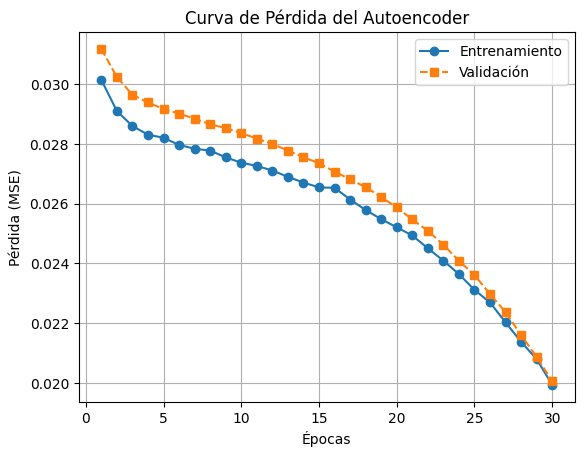

In [194]:
# Graficar las curvas de pérdida
plt.plot(range(1, num_epochs + 1), perdida_epoch_train, label="Entrenamiento", marker='o')
plt.plot(range(1, num_epochs + 1), perdida_epoch_valid, label="Validación", marker='s', linestyle='dashed')

plt.xlabel("Épocas")
plt.ylabel("Pérdida (MSE)")
plt.title("Curva de Pérdida del Autoencoder")
plt.legend()
plt.grid(True)
plt.show()

Cabe destacar que los resultados aquí obtenidos dependen extremadamente de la aleatoriedad de la ejecución. Cuando se ejecutan el script diferentes veces aparecen resultados muy variopintos de las curvas de error. En unas el error de validación es mayor que el de entrenamiento, pero muchas otras veces no es así. Creemos que depende también especialmente de la dificultad de ciertos datos para almacenarse en las variables latentes y mantener toda la información, ya que no todos los audios son igual de complejos de recomponer.

De hecho, vamos a mostrar la gráfica de error por batches del entrenamiento para hacer mejor visible la evolución del procesado.

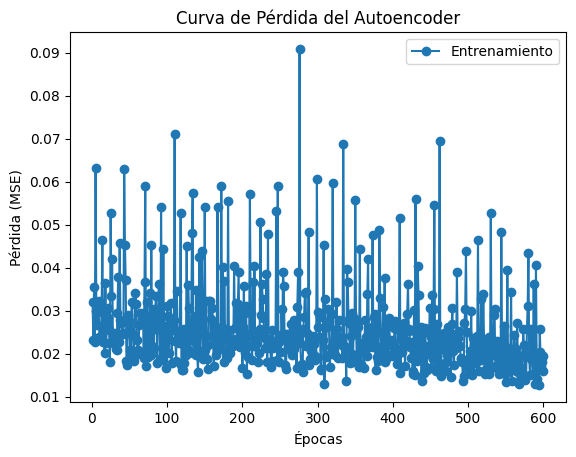

In [195]:
plt.plot(range(1, len(perdida_train)+1), perdida_train, label="Entrenamiento", marker='o')
plt.xlabel("Épocas")
plt.ylabel("Pérdida (MSE)")
plt.title("Curva de Pérdida del Autoencoder")
plt.legend()
plt.show()

Aquí es visible que, como los batches tienen un tamaño relativamente pequeño, el aprendizaje en cada batch está siendo ligeramente caótico, y eso limita la capacidad de aprendizaje del modelo.

## Reconstrucción

Vamos a ver el resultado, una vez preentrenado el modelo, para ver cómo reconstruye un audio aleatorio de fuera del conjunto de entrenamiento y validación, esta única muestra puede resultarnos como un ejemplo de conjunto de test.

Primero mostramos el espectograma del dato original y cómo suena

In [196]:
onda, samp_rt = torchaudio.load("./TEST/" + "DESCONOCIDO.wav") # Cargamos
f, s = SplitAudio(onda, sample_rate = samp_rt, new_sample_rate = 16000) # Lo dividimos en el clip de 4,2 segundos
s_spec, s_maxi, s_mini = Preprocessing(s, 16000, resampler_f = False) # Convertimos el audio escuchado a espectograma
plt.imshow(s_spec,origin='lower') # Mostramos ese espectograma
plt.show()

Audio(s.numpy(), rate=16000) # Lo escuchamos

LibsndfileError: Error opening './TEST/DESCONOCIDO.wav': System error.

Ahora que ya conocemos el dato original, veamos qué ocurre cuando lo pasamos por el autoencoder

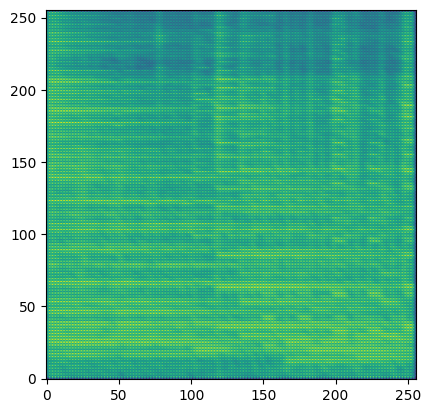

In [ ]:
reconstruccion = autoencoder.decoder(autoencoder.encoder(torch.stack([s_spec]).unsqueeze(1))) # Lo pasamos por el autoencoder
plt.imshow(reconstruccion[0][0].detach().numpy(),origin='lower') # Mostramos el espectograma
plt.show()

reescuchable = Reconstruction(reconstruccion[0][0], maxi=s_maxi, mini=s_mini) # Lo reconstruimos de espectograma a audio
Audio(reescuchable.detach().numpy(), rate=16000) # Escuchamos la reconstrucción

Es claramente notorio que la recostrucción realizada por este autoencoder simple deja bastante que desear, pese a que en el espectograma todavía se vislumbre una cierta tendencia a asemejarse al original, el ruido producido denota lo contrario.